In [1]:
from tqdm import tqdm_notebook
import random
import numpy as np
import matplotlib.pyplot as plt


from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, BatchNormalization, Reshape, Dropout, Activation, UpSampling2D, LeakyReLU

from keras.models import load_model
from keras.initializers import RandomNormal
np.random.seed(1000)

Using TensorFlow backend.


In [14]:
def set_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val


def plot_grid(images, size=5):
    img = images.reshape(images.shape[:-1])
    for i in range(size**2):
        plt.subplot(size, size, i + 1)
        plt.imshow(random.choice(img), cmap='binary')
        plt.axis('off')
    plt.show()


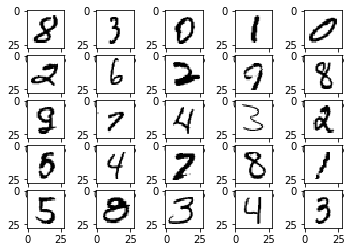

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape + (1,))
x_train = x_train.astype('float32')
x_train = (x_train - 127.5)/127.5
# plot_grid(x_train)

img_shape = x_train[0].shape

plot_grid(x_train)

In [4]:
adam = Adam(lr=2e-4, beta_1=0.5)
# sgd = SGD(lr=1e-3)

In [5]:
# Build discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

In [6]:
# Build generative model
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, kernel_initializer=RandomNormal(stddev=0.02)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2DTranspose(64, kernel_size=(5, 5), padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2DTranspose(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
__________

In [7]:
# Build GAN
discriminator.trainable = False
ganInput = Input(shape=(100,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [8]:
# Pre-Train discriminator
n = len(x_train)
# Generate random noise images
noise = np.random.normal(0, 1, size=[n, 100])
generated_img = generator.predict(noise)
disc_x_train = np.vstack([x_train, generated_img])
disc_y_train = np.zeros((2 * n, 1))
disc_y_train[:n] = 1


# # Pretraing
# #disc_model.load_weights('disc_model.h5')
discriminator.fit(disc_x_train, disc_y_train, validation_split=0.25, epochs=1, batch_size=128, shuffle=True)
discriminator.save_weights('disc_model.h5')


Train on 90000 samples, validate on 30000 samples
Epoch 1/1
90000/90000 [==============================] - 4s - loss: 0.0140 - val_loss: 1.0549e-04


HBox(children=(IntProgress(value=0, max=25000), HTML(value=u'')))

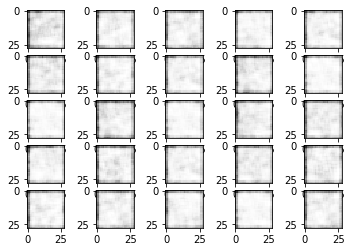

-0.021223 8.06413
-0.0109217 0.0232666
0.200599 0.0399694
0.501777 0.169923
0.576095 0.732642
0.673625 0.695718
0.577613 0.301523
0.577895 0.492057
0.756427 0.674128
0.652762 0.684158


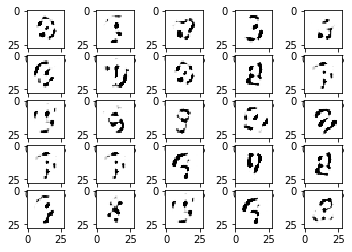

0.647529 0.643787
0.684215 0.682093
0.711529 0.757919
0.67991 0.678365
0.66282 0.758337
0.6793 0.784953
0.676351 0.692067
0.655447 0.664031
0.592583 0.627629
0.73067 0.733758


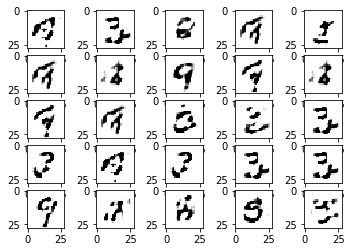

0.648747 0.766009
0.639838 0.728236
0.630667 0.697638
0.647361 0.782832
0.678834 0.752825
0.608902 0.676072
0.692823 0.678876
0.693877 0.846189
0.690518 0.768834
0.715614 0.769003


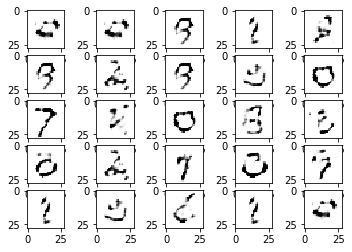

0.703281 0.683578
0.695264 0.731318
0.665912 0.724164
0.648016 0.670069
0.617961 0.815319
0.64378 0.792427
0.639735 0.762372
0.643422 0.819988
0.616091 0.688094
0.659142 0.642386


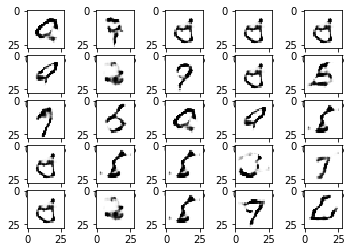

0.655193 0.764952
0.679283 0.741779
0.69678 0.716663
0.711061 0.63992
0.688787 0.705953
0.670674 0.744912
0.694368 0.722303
0.695078 0.783837
0.68408 0.790426
0.671433 0.781932


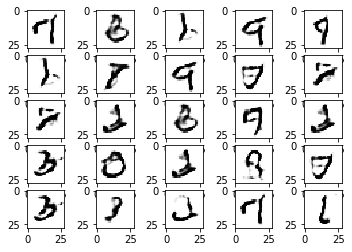

0.644386 0.734829
0.655589 0.731052
0.645003 0.706098
0.634052 0.681567
0.662776 0.642411
0.676946 0.755975
0.684991 0.705373
0.674587 0.64432
0.648624 0.789715
0.642427 0.714168


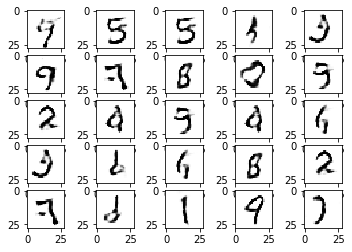

0.6286 0.740203
0.642147 0.683898
0.657904 0.766743
0.680513 0.812819
0.66307 0.771618
0.672488 0.789022
0.695707 0.943803
0.679772 0.659878
0.64989 0.759011
0.625864 0.735416


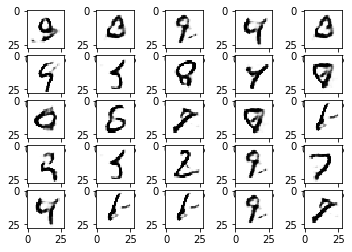

0.659502 0.844766
0.63272 0.78758
0.673853 0.686748
0.683081 0.814032
0.686223 0.863092
0.686878 0.823251
0.659616 0.6451
0.622297 0.886829
0.638627 0.824627
0.68963 0.545476


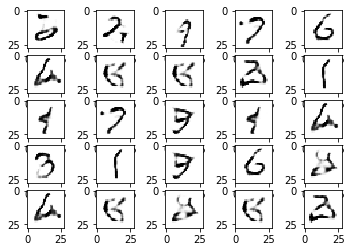

0.664348 0.822326
0.618825 0.812569
0.668424 0.663339
0.678169 0.77986
0.679381 0.655986
0.658562 0.882641
0.634033 0.854141
0.686998 0.630126
0.656739 0.753776
0.649486 0.968481


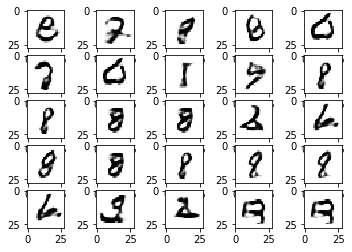

0.644149 0.911486
0.657129 0.7131
0.629466 0.784406
0.608822 0.772565
0.644817 0.799492
0.664256 0.822967
0.644619 0.885997
0.650187 0.756701
0.667139 0.6581
0.652412 0.99534


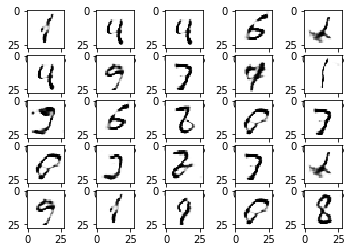

0.65129 1.11957
0.645119 0.735761
0.633874 0.829604
0.649097 0.881559
0.635373 0.89912
0.643415 0.730861
0.647354 0.795312
0.657196 0.915363
0.608854 0.871707
0.633117 0.768801


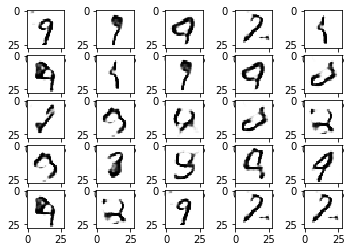

0.624442 0.882608
0.63615 0.821371
0.625829 0.836085
0.650879 0.993572
0.648574 0.897586
0.64699 1.00315
0.654391 0.729575
0.656851 0.897221
0.663661 0.830268
0.635794 0.820993


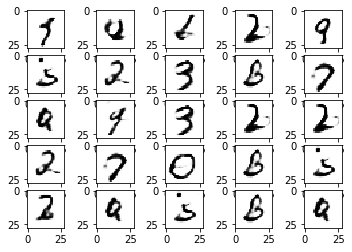

0.642654 1.05553
0.653992 0.792958
0.62196 0.926444
0.656459 0.764259
0.62861 0.797516
0.638553 1.01703
0.633727 0.873047
0.680165 0.739423
0.631993 0.738236
0.6455 0.657931


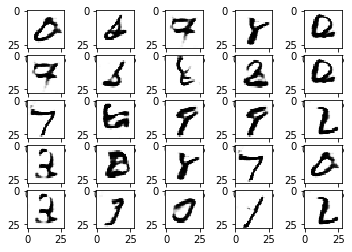

0.639376 0.714845
0.649002 0.764672
0.641201 0.761671
0.61658 0.771329
0.640487 0.885825
0.613688 0.787199
0.65031 0.94369
0.635649 0.815816
0.62566 0.945926
0.630919 0.772992


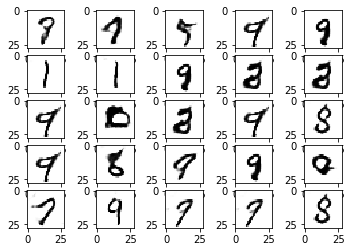

0.62393 0.870464
0.65771 0.806837
0.623617 0.872539
0.627822 0.951087
0.628432 0.872038
0.632384 0.851348
0.654688 0.873614
0.630317 0.8145
0.642071 0.749725
0.634542 0.709345


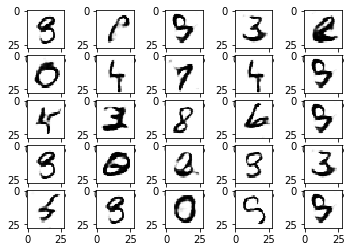

0.638973 0.926103
0.64279 0.769201
0.671273 0.80928
0.608986 0.806889
0.638922 0.822794
0.624024 0.895635
0.648826 0.967453
0.644933 0.765834
0.621771 0.963242
0.610347 1.04729


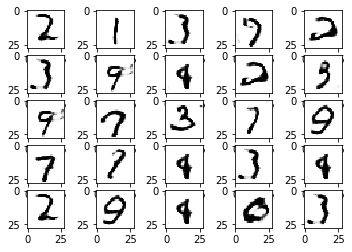

0.661502 0.840805
0.592156 0.787821
0.646248 0.685461
0.645014 0.940164
0.651872 0.902637
0.638174 0.765224
0.61491 0.9201
0.660732 0.853361
0.66305 0.931673
0.649608 0.746839


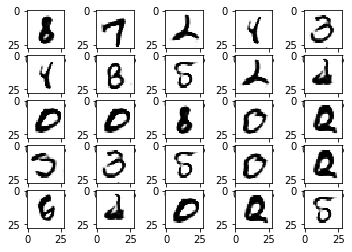

0.621181 0.642996
0.631118 0.868288
0.644093 0.820767
0.653918 0.959744
0.642335 0.869787
0.649146 0.71352
0.625407 0.836101
0.614669 0.923103
0.63186 0.85959
0.610778 0.788637


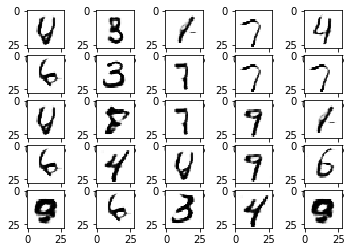

0.643168 0.964809
0.62138 0.686049
0.673908 0.655662
0.638141 1.13036
0.640749 0.760818
0.630792 0.835065
0.610633 0.786054
0.626604 0.627135
0.631498 0.872382
0.626591 0.840253


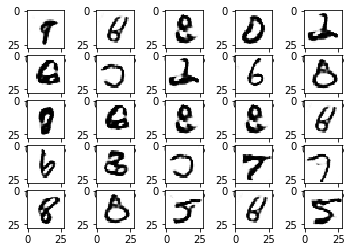

0.615863 0.80346
0.616303 0.747048
0.613985 0.727596
0.625312 0.788171
0.635977 0.895678
0.632278 0.765783
0.632168 0.818616
0.654666 1.01164
0.622548 0.881492
0.616349 0.87144


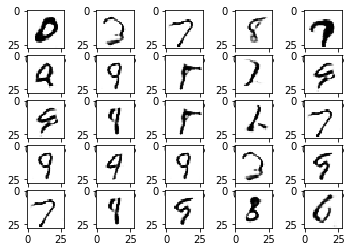

0.622046 0.768095
0.622821 0.92763
0.640489 0.829351
0.609115 0.890325
0.655031 0.869508
0.628621 0.827931
0.62198 0.96359
0.644259 0.896702
0.636623 0.854327
0.607481 0.866375


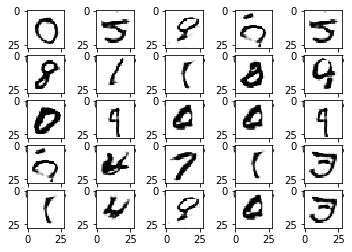

0.613112 0.901245
0.59804 0.835907
0.621666 0.844993
0.606828 0.830823
0.630099 0.858565
0.619268 0.776874
0.618513 1.01391
0.645167 0.724413
0.627774 0.944703
0.64909 0.886041


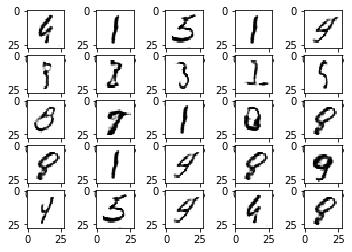

0.589817 0.991513
0.645682 0.787856
0.627852 0.774192
0.635907 0.955231
0.611648 0.963634
0.622842 0.769155
0.625455 0.825546
0.635175 0.883788
0.648219 0.766909
0.649949 0.836506


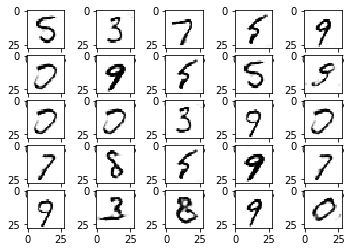

0.656555 0.627962
0.623339 0.817427
0.656428 0.976256
0.602877 0.930698
0.615242 0.744488
0.634132 0.888822
0.624321 1.00221
0.623792 0.880453
0.641997 0.769147
0.600749 0.801891


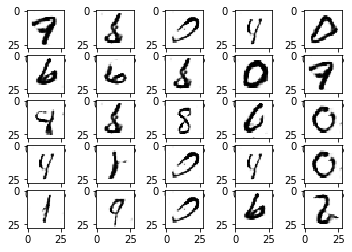

0.614263 0.996101
0.63613 0.753631
0.649938 1.04326
0.644303 0.909305
0.642734 0.916871
0.629195 0.887148
0.655628 1.0151
0.633703 1.05963
0.618099 1.03897
0.630676 0.683041


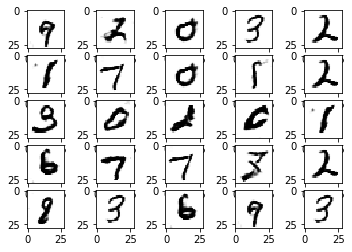

0.602603 0.854661
0.639135 0.872866
0.630965 0.778196
0.623368 0.811852
0.611036 0.847609
0.628516 0.991917
0.652762 0.798742
0.617643 0.810962
0.640172 0.996097
0.653327 0.864356


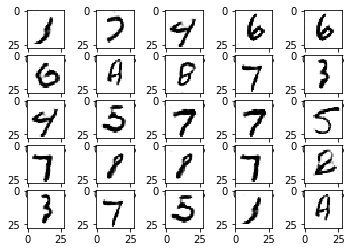

0.624412 0.932202
0.654269 0.985979
0.598553 0.956779
0.621553 1.12709
0.640654 0.868711
0.634895 0.824504
0.617583 1.01662
0.634657 0.889017
0.596192 0.990698
0.623392 0.725834


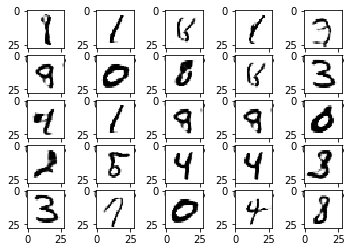

0.630473 0.84697
0.638623 0.799259
0.637766 1.14805
0.592308 0.958256
0.623383 0.747065
0.634933 0.902372
0.618601 0.91089
0.653287 0.873279
0.615839 0.894578
0.629237 0.812825


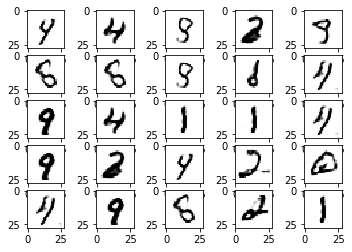

0.623152 0.807452
0.629793 0.765906
0.595562 0.746013
0.659931 0.845105
0.612314 0.997695
0.614861 0.83113
0.619843 0.796805
0.641738 0.859979
0.626477 0.931077
0.603853 1.03437


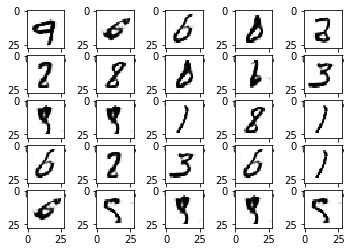

0.63146 1.08577
0.600589 0.848252
0.629905 0.900884
0.649682 1.07179
0.6033 0.967165
0.60134 0.725012
0.627119 0.887884
0.620589 0.74202
0.643549 0.972511
0.603009 0.983713


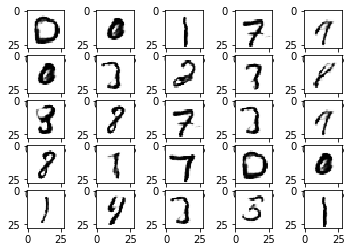

0.599393 0.844154
0.625567 0.792126
0.616388 0.766947
0.63644 1.02563
0.631388 0.844062
0.608539 0.794994
0.593631 0.884923
0.61032 0.710474
0.605353 0.939007
0.600009 0.96061


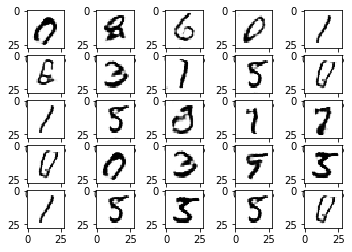

0.618545 0.948907
0.641104 0.625297
0.584932 0.791496
0.609893 0.861411
0.613702 0.94338
0.618871 0.697987
0.626568 0.90559
0.63145 0.984021
0.590259 1.07165
0.619257 0.833399


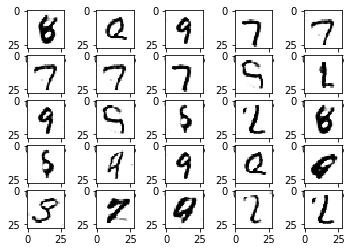

0.620487 0.884423
0.609596 0.90045
0.639867 1.1061
0.628015 1.05349
0.636752 0.884363
0.650125 0.946279
0.597051 0.911551
0.600539 1.01337
0.626041 0.927595
0.60673 1.34114


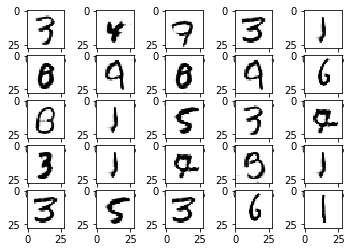

0.654405 0.927833
0.620455 0.869775
0.593632 0.899555
0.634503 1.09387
0.593844 0.762587
0.608717 0.911675
0.605496 0.873295
0.596294 0.966864
0.663806 1.13385
0.58694 0.78883


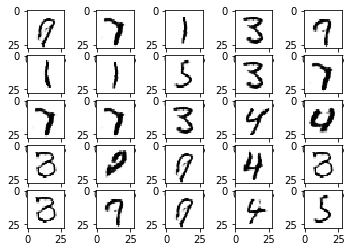

0.600645 0.859902
0.615336 0.95193
0.639087 0.782092
0.623848 1.0938
0.598734 0.784927
0.589817 1.02697
0.621406 0.91432
0.617169 0.772357
0.653829 0.695523
0.665284 0.942411


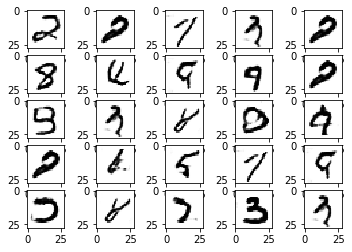

0.631219 0.936714
0.675358 0.734914
0.608012 0.850604
0.618387 0.921166
0.605811 1.05325
0.625729 0.918983
0.631614 1.14639
0.635211 0.864236
0.630473 0.840509
0.632174 1.01015


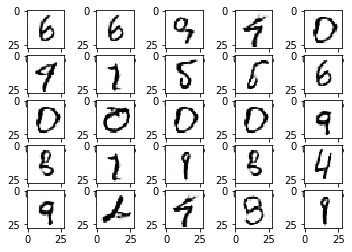

0.622405 1.03921
0.641508 1.1251
0.656691 0.816387
0.587479 0.816449
0.623382 0.956414
0.596153 0.832976
0.624311 0.860898
0.597099 0.873878
0.643155 0.866147
0.621121 0.799278


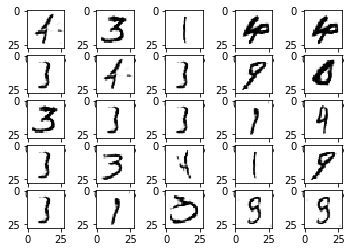

0.609552 0.949617
0.586671 1.0301
0.62139 0.956774
0.619265 1.14772
0.611477 0.91831
0.604578 1.1595
0.64033 1.03048
0.61915 1.0108
0.602796 1.14965
0.577751 1.02402


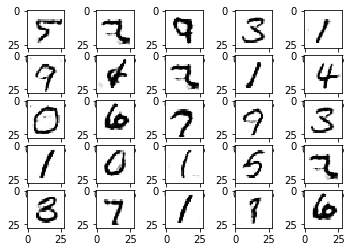

0.626121 1.38535
0.596909 0.778675
0.578597 0.706608
0.613006 1.07059
0.602096 0.911062
0.594523 1.0195
0.591846 0.979305
0.611411 0.950593
0.592907 0.825663
0.641903 0.963867


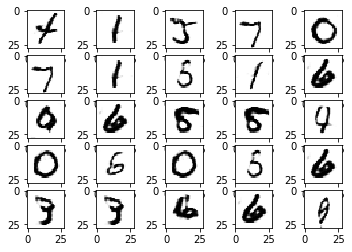

0.607626 0.844163
0.612864 0.980946
0.634672 0.892829
0.601529 0.973838
0.614848 1.0612
0.604041 0.981452
0.594223 0.693021
0.611326 0.834666
0.614193 0.675145
0.596016 0.869383


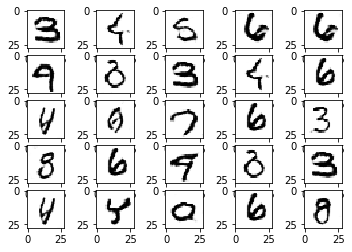

0.610078 0.834345
0.606921 0.992284
0.583891 0.919338
0.623224 0.891062
0.645837 0.846472
0.63321 0.917415
0.569492 1.04891
0.615829 0.806538
0.632406 0.916695
0.599299 0.877938


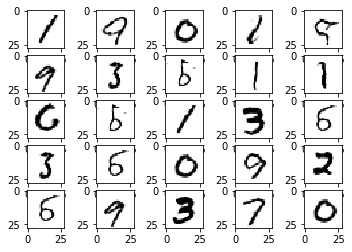

0.614537 1.21316
0.597515 0.877271
0.583398 0.96139
0.613733 0.993916
0.61158 0.875641
0.588304 1.00403
0.580688 0.762514
0.598557 0.963492
0.57094 0.977386
0.639272 1.02953


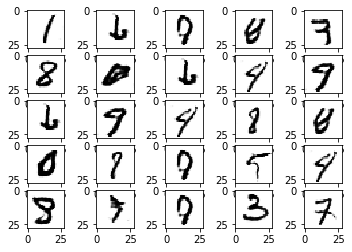

0.605336 0.990513
0.602431 0.820487
0.618137 0.974671
0.599361 0.82537
0.620715 0.871124
0.575333 1.04322
0.639387 0.8078
0.60323 1.15643
0.602218 1.0127
0.633841 1.03459


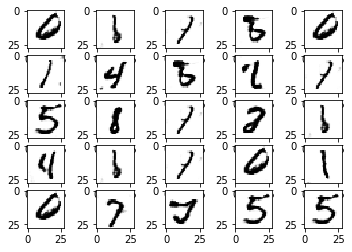

0.590244 0.80826
0.629077 0.784239
0.618645 0.907391
0.593613 1.22103
0.578005 0.86954
0.594006 1.00514
0.600219 1.04826
0.60229 1.04125
0.604102 0.855556
0.604569 1.06635


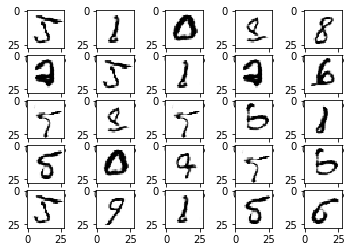

0.591237 1.00794
0.575053 0.883267
0.604994 0.89175
0.609875 0.812923
0.583353 0.782149
0.608254 0.856439
0.6099 0.926333
0.615303 0.834867
0.619207 1.04466
0.617351 0.980328


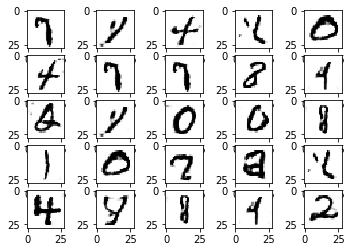

0.597273 0.817366
0.57638 1.07136
0.62637 1.16917
0.606329 0.913605
0.596828 0.939663
0.611407 0.983161
0.592446 1.07804
0.615741 0.867101
0.597638 1.12937
0.58934 0.932388


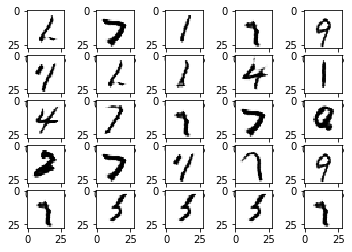

0.582434 0.835152
0.624255 0.930106
0.592266 1.10613
0.616089 0.874318
0.582453 1.01217
0.626201 0.960748
0.586035 0.84906
0.595792 0.961715
0.610492 0.826002
0.610828 1.1419


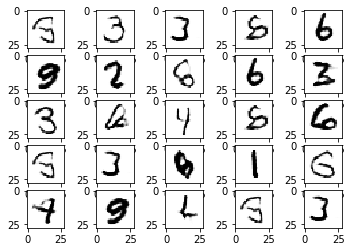

0.617111 0.935297
0.604036 1.00404
0.609772 0.938285
0.587686 0.867915
0.613702 0.940093
0.561555 1.00759
0.608467 1.00713
0.600875 0.889434
0.597836 1.05762
0.65073 1.00108


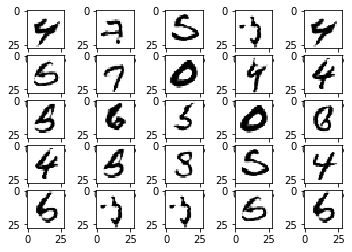

0.608575 1.06166
0.61263 0.96468
0.622891 0.936002
0.607332 1.10585
0.595382 0.952722
0.581945 0.977219
0.619009 0.953075
0.632773 0.942637
0.662137 0.851068
0.57392 0.93157


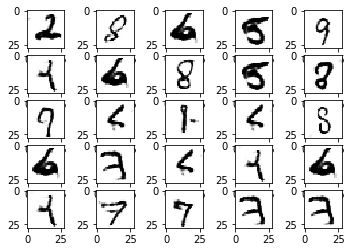

0.588468 0.882408
0.612466 0.830596
0.615469 1.11088
0.606338 1.02828
0.613395 1.04088
0.584103 0.970117
0.595525 0.961598
0.613951 1.12335
0.621844 0.855578
0.598827 1.01059



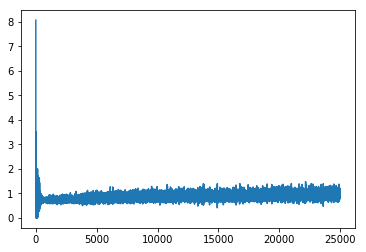

In [9]:
N = 25000
BATCH_SIZE = 256
losses = []
disc_losses = []
for i in tqdm_notebook(range(N)):
    real_img = list(map(lambda _: random.choice(x_train), range(BATCH_SIZE)))

    noise = np.random.normal(0, 1, size=[BATCH_SIZE, 100])
    generated_img = generator.predict(noise)

    disc_x_train = np.vstack([real_img, generated_img])
    disc_y_train = np.zeros((2 * BATCH_SIZE, 1))
    # Label smoothing
    disc_y_train[:BATCH_SIZE] = np.random.normal(1, 0.3, size=[BATCH_SIZE, 1])
    disc_y_train[BATCH_SIZE:] = np.random.normal(0, 0.3, size=[BATCH_SIZE, 1])

    discriminator.trainable = True
    disc_loss = discriminator.train_on_batch(disc_x_train, disc_y_train)

    # Train generator
    discriminator.trainable = False
    noise = np.random.normal(0, 1, size=[BATCH_SIZE, 100])
    gan_y_train = np.ones((BATCH_SIZE, 1)) # Pretend these images are real
    loss = gan.train_on_batch(noise, gan_y_train)
    
    
    losses.append(loss)
    disc_losses.append(disc_loss)
    
    if i % 500 == 0:
        noise = np.random.normal(0, 1, size=[25, 100])
        generated_img = generator.predict(noise)
        plot_grid(generated_img)
        plt.show()
    if i % 50 == 0:
        print disc_loss, loss
plt.plot(losses)
plt.show()

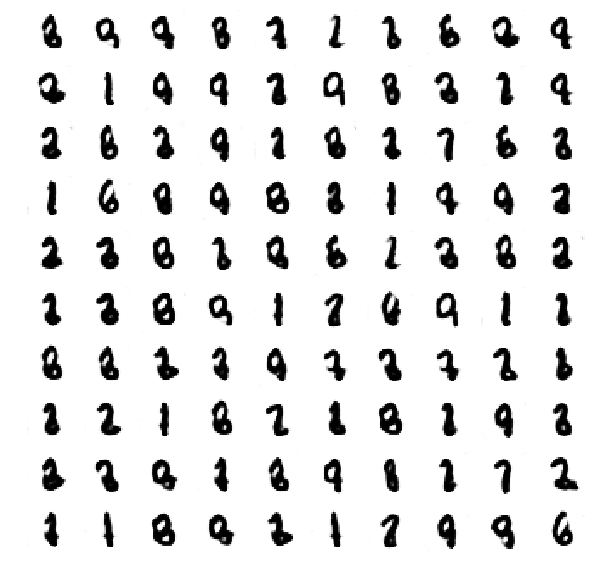

In [17]:
noise = np.random.uniform(0, 1, size=[100, 100])

generated_img = generator.predict(noise)
plt.figure(figsize=(10,10))
plot_grid(generated_img, 10)
